#**LSGAN: CelebA**  

**Model** 
> Generator: DCGAN  
> Discriminator: PatchGAN  
> GAN Loss: LSGAN
  
**Data**  
> https://www.kaggle.com/jessicali9530/celeba-dataset  

In [ ]:
import torch
import torch.nn as nn
import torchvision.utils as utils
import torch.optim as optim 
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import itertools

import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pickle
import random

In [ ]:
workers = 2
batch_size = 64
nz = 100
nc = 3
image_size = 64

epochs = 50
lr = 0.0002
beta1 = 0.5
lamb = 100
isCuda = True

device = torch.device("cuda:0" if (torch.cuda.is_available() and isCuda) else "cpu")
torch.backends.cudnn.benchmark = True

model_saved_dir = "/content/drive/MyDrive/Colab Notebooks/AirForce/model/CelebA"

print("Device: ", end="")
print(device)

Device: cuda:0


In [ ]:
def cuda_status():
  print(torch.cuda.get_device_name(0))
  print('Memory Usage:')
  print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
  print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

## Data Loading

In [ ]:
import os.path
from google.colab import files

if os.path.isfile('/content/kaggle.json'):
  print("Already kaggle.json exsits.")
else:
  files.upload()
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/ 
  !chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jessicali9530/celeba-dataset
if os.path.isdir('/content/img_align_celeba'):
  print("Already unzip.")
else:
  !unzip -q celeba-dataset.zip
  print("Unzip Complete!")

Already kaggle.json exsits.
celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Already unzip.


In [ ]:
dataset = datasets.ImageFolder(root='/content/img_align_celeba',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

In [ ]:
# Restore images to suitable images of opencv style
def ImgForPlot(img):
  img = np.einsum('ijk->jki', img)
  img = (127.5*(img+1)).astype(np.uint8)
  return img

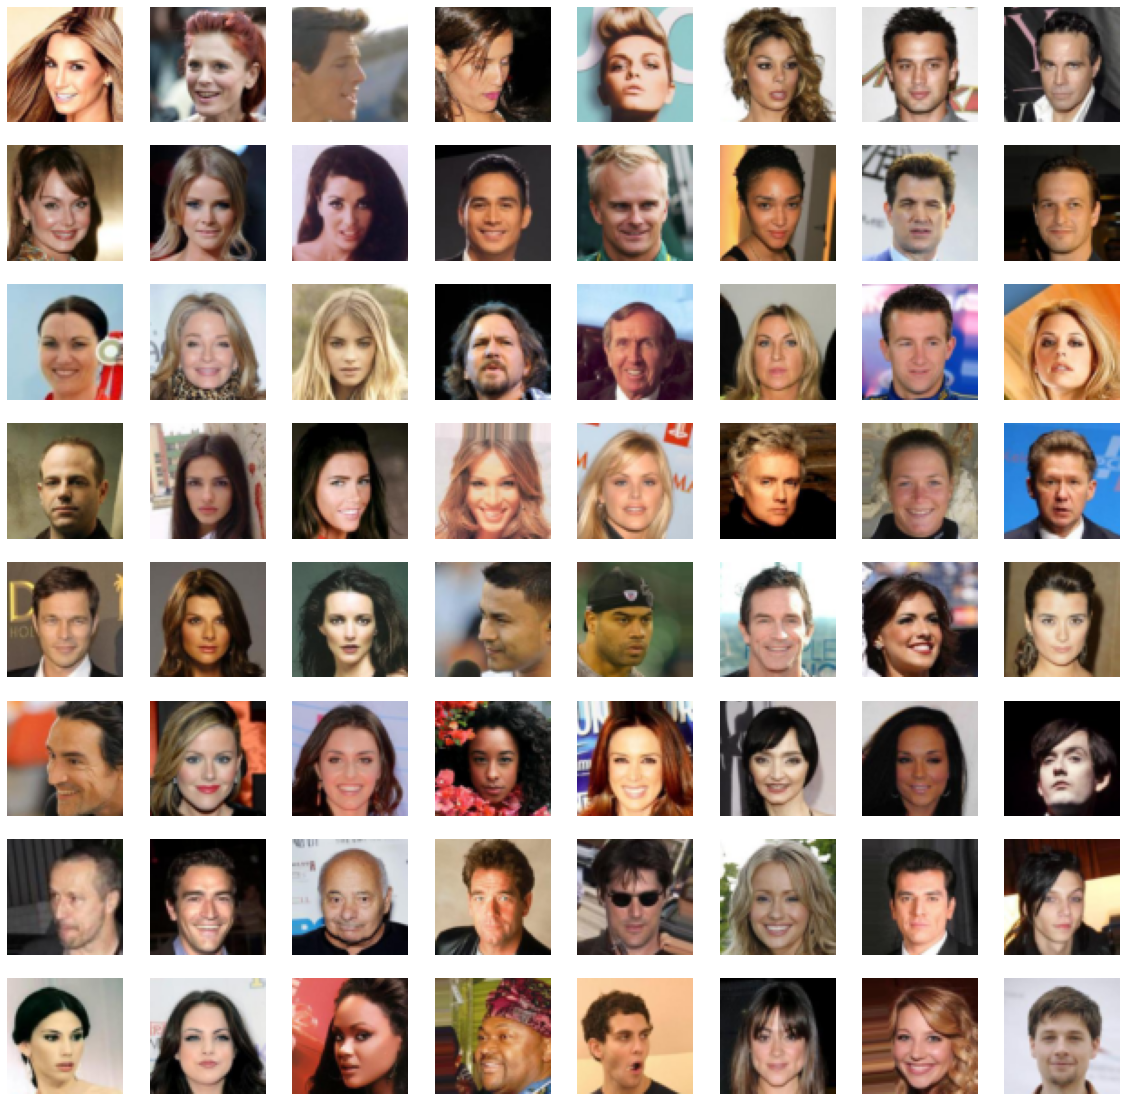

In [ ]:
fig = plt.figure(figsize=(20,20))

for k in range(64):
  img, idx = dataset[k]
  ax = fig.add_subplot(8, 8, k+1)
  ax.imshow(ImgForPlot(img))
  ax.axis("off")

plt.show()

## Generator  

1x1x(nz) → 4x4x1024 → 8x8x512 → 16x16x256 → 32x32x128 → 64x64x3



In [ ]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
        # 1 x 1 x nz
        nn.ConvTranspose2d(nz, 1024, 4, 1, 0, bias=False),
        nn.ReLU(inplace=True),
        # 4 x 4 x 1024
        nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        # 8 x 8 x 512
        nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        # 16 x 16 x 256
        nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        # 32 x 32 x 128
        nn.ConvTranspose2d(128, nc, 4, 2, 1, bias=False),
        nn.Tanh()
        # 64 x 64 x nc
    )

  def forward(self, x):
    return self.main(x)

## Discriminator

64x64x3 → 32x32x64 → 16x16x128 → 8x8x256 → 4x4x512 → 1x1x1

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        # 64x64x3
        nn.Conv2d(nc, 64, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # 32x32x64
        nn.Conv2d(64, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        # 16x16x128
        nn.Conv2d(128, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        # 8x8x256
        nn.Conv2d(256, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),
        # 4x4x512
        nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
        # 1x1x1
    )

  def forward(self, x):
    return self.main(x)

## Making models & Weight initialization

In [ ]:
netG = Generator().to(device)
netD = Discriminator().to(device)

In [ ]:
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

## (Option) Load from drive


In [ ]:
model_name = 'LSGAN_CelebA_autosave'

img_list_path = F"{model_saved_dir}/{model_name}_img_list.txt"
losses_path = F"{model_saved_dir}/{model_name}_losses.txt"
G_path = F"{model_saved_dir}/{model_name}_G.pt"
D_path = F"{model_saved_dir}/{model_name}_D.pt"

with open(img_list_path, 'rb') as f:
  img_list = pickle.load(f)
with open(losses_path, 'rb') as f:
  G_losses, D_losses = pickle.load(f)

netG.load_state_dict(torch.load(G_path))
netD.load_state_dict(torch.load(D_path))

<All keys matched successfully>

## Loss Functions and Optimizers


In [ ]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_num = 1
fake_num = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1,0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1,0.999))

## Training

In [ ]:
start_epoch = 0
continueTrain = False

if start_epoch == 0 and not continueTrain:
  img_list, G_losses, D_losses = [], [], []

model_name = 'LSGAN_CelebA_autosave'

img_list_path = F"{model_saved_dir}/{model_name}_img_list.txt"
losses_path = F"{model_saved_dir}/{model_name}_losses.txt"
G_path = F"{model_saved_dir}/{model_name}_G.pt"
D_path = F"{model_saved_dir}/{model_name}_D.pt"

netD.train()
netG.train()
for ep in range(start_epoch, epochs):
  for batch_idx, (image, lbl) in enumerate(dataloader, 0):

    b_size = image.shape[0]
    image = Variable(image).cuda()
    label = torch.full((b_size,), real_num, device=device)
    label = label.type(torch.cuda.FloatTensor)
    
    # 1. Update Discriminator
    # 1-1. Train with Real Batch
    netD.zero_grad()

    output = netD(image).view(-1)
    errD_real = criterion(output, label)
    errD_real.backward()
    D_x = output.mean().item()

    # 1-2. Train with Fake Batch
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    fake = netG(noise)
    label.fill_(fake_num)

    output = netD(fake.detach()).view(-1)
    errD_fake = criterion(output, label)
    errD_fake.backward()
    D_G_z1 = output.mean().item()

    errD = 0.5 * (errD_real + errD_fake)
    optimizerD.step() 
    
    # 2. Update Generator
    netG.zero_grad()
    label.fill_(real_num)

    output = netD(fake).view(-1)
    errG = criterion(output, label)
    errG.backward()
    D_G_z2 = output.mean().item()
    optimizerG.step()

    if batch_idx % 50 == 49:
      print('[%3d/%3d][%3d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' 
            % (ep+1, epochs, batch_idx+1, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
      G_losses.append(errG.item())
      D_losses.append(errD.item())
  
  with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
    img_list.append(fake)

  torch.save(netG.state_dict(), G_path)
  torch.save(netD.state_dict(), D_path)

  with open(img_list_path, 'wb') as f:
    pickle.dump(img_list, f)
  with open(losses_path, 'wb') as f:
    pickle.dump((G_losses, D_losses), f)

[  1/ 50][ 50/3166]	Loss_D: 0.2034	Loss_G: 7.2136	D(x): 0.8815	D(G(z)): 0.0267 / 0.0014
[  1/ 50][100/3166]	Loss_D: 0.1997	Loss_G: 8.7153	D(x): 0.8265	D(G(z)): 0.0269 / 0.0004
[  1/ 50][150/3166]	Loss_D: 0.3652	Loss_G: 4.2503	D(x): 0.7884	D(G(z)): 0.3219 / 0.0254
[  1/ 50][200/3166]	Loss_D: 0.5391	Loss_G: 2.3354	D(x): 0.5170	D(G(z)): 0.1762 / 0.1411
[  1/ 50][250/3166]	Loss_D: 0.1783	Loss_G: 4.0095	D(x): 0.8511	D(G(z)): 0.1480 / 0.0371
[  1/ 50][300/3166]	Loss_D: 0.5268	Loss_G: 2.3203	D(x): 0.8335	D(G(z)): 0.5148 / 0.1391
[  1/ 50][350/3166]	Loss_D: 0.7112	Loss_G: 4.2047	D(x): 0.7210	D(G(z)): 0.5768 / 0.0317
[  1/ 50][400/3166]	Loss_D: 0.4154	Loss_G: 2.8966	D(x): 0.7552	D(G(z)): 0.3390 / 0.0949
[  1/ 50][450/3166]	Loss_D: 0.4105	Loss_G: 2.3518	D(x): 0.6069	D(G(z)): 0.1628 / 0.1306
[  1/ 50][500/3166]	Loss_D: 0.4208	Loss_G: 3.3211	D(x): 0.7031	D(G(z)): 0.2805 / 0.0569
[  1/ 50][550/3166]	Loss_D: 0.4534	Loss_G: 4.1112	D(x): 0.6985	D(G(z)): 0.3267 / 0.0225
[  1/ 50][600/3166]	Loss_D: 0.55

### Check last fake images

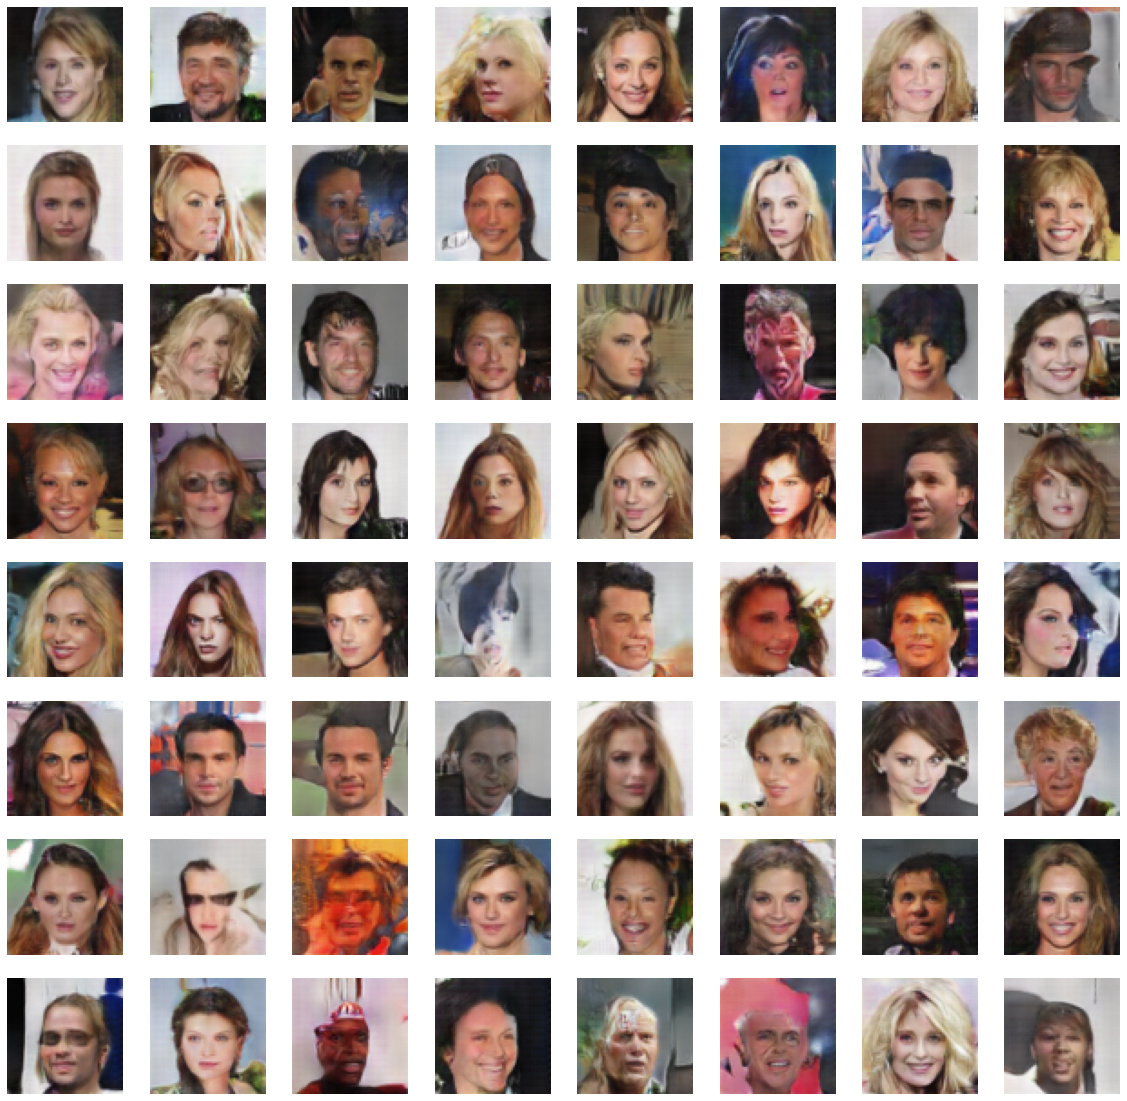

In [ ]:
fig = plt.figure(figsize=(20,20))

for k in range(64):
  img = img_list[-4][k]
  ax = fig.add_subplot(8, 8, k+1)
  ax.imshow(ImgForPlot(img))
  ax.axis("off")

plt.show()

### Plot losses of generator and discriminator

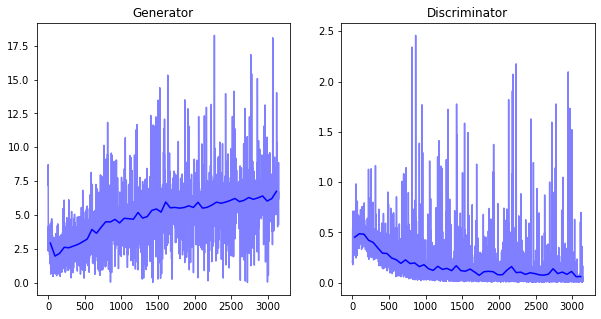

In [ ]:
G_losses_ep = []
D_losses_ep = []

cnt = 0
for i in range(50):
  G_sum, D_sum = 0.0, 0.0
  for j in range(63):
    G_sum += G_losses[cnt]
    D_sum += D_losses[cnt]
    cnt += 1
  G_losses_ep.append(G_sum/63.0)
  D_losses_ep.append(D_sum/63.0)

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1)
ax.plot(range(len(G_losses)), G_losses, c=[0, 0, 1, 0.5])
ax.plot(range(31, len(G_losses)+31, 63), G_losses_ep, c=[0, 0, 1, 1])
ax.set_title("Generator")
ax = fig.add_subplot(1, 2, 2)
ax.plot(range(len(D_losses)), D_losses, c=[0, 0, 1, 0.5])
ax.plot(range(31, len(D_losses)+31, 63), D_losses_ep, c=[0, 0, 1, 1])
ax.set_title("Discriminator")

plt.show()

## Save models and images in drive

In [ ]:
model_name = 'LSGAN_CelebA'

img_list_path = F"{model_saved_dir}/{model_name}_img_list.txt"
losses_path = F"{model_saved_dir}/{model_name}_losses.txt"
noise_path = F"{model_saved_dir}/{model_name}_noise.txt"
G_path = F"{model_saved_dir}/{model_name}_G.pt"
D_path = F"{model_saved_dir}/{model_name}_D.pt"

torch.save(netG.state_dict(), G_path)
torch.save(netD.state_dict(), D_path)

with open(img_list_path, 'wb') as f:
  pickle.dump(img_list, f)
with open(losses_path, 'wb') as f:
  pickle.dump((G_losses, D_losses), f)
with open(noise_path, 'wb') as f:
  pickle.dump(fixed_noise, f)

print(F"Saved {model_name} Completed!")

Saved LSGAN_CelebA Completed!


## Animation

In [ ]:
from matplotlib.animation import FuncAnimation
from matplotlib import rcParams
from IPython.display import HTML, clear_output

rcParams['animation.embed_limit'] = 2**128

ims = []
SIZE = 10
fig = plt.figure(figsize=(SIZE, SIZE))

imgs = img_list[0].tolist()
for j in range(64):
  ax = fig.add_subplot(8, 8, j+1)
  im = ax.imshow(ImgForPlot(imgs[j]))
  ax.axis("off")
  ims.append(im)

def init():
  for j in range(64):
    ims[j].set_data([[]])

  return tuple(ims)

def update(frame):
  imgs = img_list[frame].tolist()
  
  for j in range(64):
    img = imgs[j]
    ims[j].set_array(ImgForPlot(img))

  return tuple(ims)

ani = FuncAnimation(fig=fig, init_func=init, func=update, interval=200, blit=True, frames=range(len(img_list)))

plt.show()
clear_output(wait = True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

## Test


### Find latent vector of real images with backprop

In [ ]:
class latent_vector(nn.Module):
  def __init__(self):
    super(latent_vector, self).__init__()
    self.z_real = nn.Parameter(torch.randn(1, nz, 1, 1, device=device))
    self.z_real.requires_grad_()

  def forward(self):
    netG.eval()
    return netG(self.z_real)


def find_latent(target_img, iterations = 10000):
  netG.eval()

  lv = latent_vector()
  optimizerZ = optim.Adam(lv.parameters(), lr=0.01)
  criterion = nn.MSELoss()

  for iter in range(iterations):
    lv.zero_grad()
    gen_img = lv()
    loss = criterion(gen_img.view(target_img.shape), target_img)
    loss.backward()
    optimizerZ.step()

  print('Loss: %.4f' % loss.item())
  return lv.z_real

Loss: 0.0385


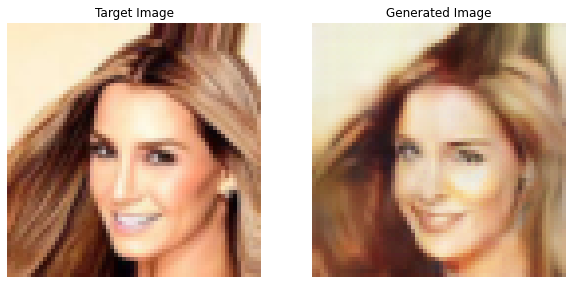

In [ ]:
target_image, _ = dataset[0]
target_z = find_latent(target_image.cuda())

netG.eval()
gen_image = netG(target_z)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(ImgForPlot(target_image))
ax.set_title('Target Image')
ax.axis("off")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(ImgForPlot(gen_image.squeeze_(0).cpu().detach().numpy()))
ax.set_title('Generated Image')
ax.axis("off")
plt.show()

### Mapping two images

In [ ]:
idx1, idx2 = 0, 1

target1, _ = dataset[idx1]
target2, _ = dataset[idx2]

z1 = find_latent(target1.cuda())
z2 = find_latent(target2.cuda())

Loss: 0.0375
Loss: 0.0462


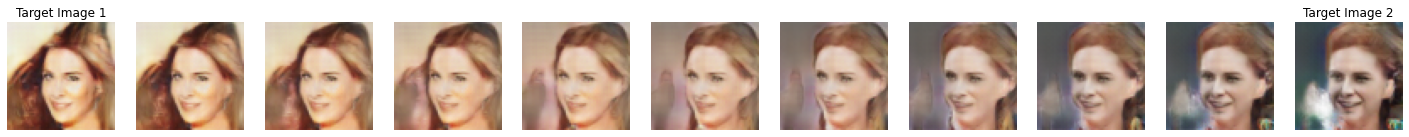

In [ ]:
netG.eval()
imgs = []
for i in range(11):
  alpha = i * 0.1
  z = z1 * (1.0 - alpha) + z2 * alpha
  img = netG(z)
  imgs.append(img.squeeze_(0).cpu().detach().numpy())

fig = plt.figure(figsize=(25, 4))
for i in range(11):
  ax = fig.add_subplot(1, 11, i+1)
  ax.imshow(ImgForPlot(imgs[i]))
  if i == 0:
    ax.set_title('Target Image 1')
  elif i == 10:
    ax.set_title('Target Image 2')
  ax.axis("off")

In [ ]:
netG.eval()
n_imgs = 100
imgs = []
for i in range(n_imgs+1):
  alpha = i * 1.0 / n_imgs
  z = z1 * (1.0 - alpha) + z2 * alpha
  img = netG(z)
  imgs.append(img.squeeze_(0).cpu().detach().numpy())

SIZE = 5
fig = plt.figure(figsize=(SIZE, SIZE))

im = plt.imshow(ImgForPlot(imgs[0]))
plt.axis('off')

def init():
  im.set_data(ImgForPlot(imgs[0]))
  return [im]

def update(frame):
  img = imgs[frame].tolist()
  im.set_array(ImgForPlot(img))

  return [im]

ani = FuncAnimation(fig=fig, init_func=init, func=update, interval=int(5000/n_imgs), blit=True, frames=range(n_imgs+1))

plt.show()
clear_output(wait = True)

ani.save('animation.gif', writer='pillow', fps=30)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.